**IMPORTING LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import random as rn
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sympy import *
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential
plt.rcParams['figure.figsize'] = [10,10]

**READING THE DATA**

In [ ]:
d = pd.read_csv('MISIG_data.csv')

t1 = np.array(d['Annual Hash Growth'])
t2 = np.array(d['Block Height'])
t3 = np.array(d['Block Interval'])
t4 = np.array(d['Block Size'])
t5 = np.array(d['Blockchain Size'])
t6 = np.array(d['Daily Blocks'])
t7 = np.array(d['Chain Value Density'])
t8 = np.array(d['Daily Transactions'])
t9 = np.array(d['Difficulty'])
t10 = np.array(d['Fee Percentage'])
t11 = np.array(d['Two-Week Hash Growth'])
t12 = np.array(d['Hash Rate'])
t13 = np.array(d['Market Capitalization'])
t14 = np.array(d['Metcalfes Law - TX'])
t15 = np.array(d['Metcalfes Law - UTXO'])
t16 = np.array(d['Miner Revenue Value'])
t17 = np.array(d['Miner Revenue'])
t18 = np.array(d['Money Supply'])
t19 = np.array(d['Output Value'])
t20 = np.array(d['Output Volume'])
t21 = np.array(d['Bitcoin Price'])
t22 = np.array(d['Quarterly Hash Growth'])
t23 = np.array(d['Total Transactions'])
t24 = np.array(d['Transaction Amount'])
t25 = np.array(d['Transaction Fees'])
t26 = np.array(d['Transaction Size'])
t27 = np.array(d['Transaction Value'])
t28 = np.array(d['Transactions per Block'])
t29 = np.array(d['Avg. UTXO Amount'])
t30 = np.array(d['UTXO Growth'])
t31 = np.array(d['UTXO Set Size'])
t32 = np.array(d['Avg. UTXO Value'])
t33 = np.array(d['Velocity - Daily'])
t34 = np.array(d['Velocity - Quarterly'])
t35 = np.array(d['Velocity of Money'])

**OBSERVING CORRELATION**

In [ ]:
def high_corr(value):
    color = 'red' if value > 0.95 or value < -0.95 else 'black'
    return 'color: %s' % color

In [ ]:
corr = d.corr()
df=pd.DataFrame(corr)
corr_mat=df.style.applymap(high_corr)
corr_mat

,Annual Hash Growth,Block Height,Block Interval,Block Size,Blockchain Size,Daily Blocks,Chain Value Density,Daily Transactions,Difficulty,Fee Percentage,Two-Week Hash Growth,Hash Rate,Market Capitalization,Metcalfes Law - TX,Metcalfes Law - UTXO,Miner Revenue Value,Miner Revenue,Money Supply,Output Value,Output Volume,Bitcoin Price,Quarterly Hash Growth,Total Transactions,Transaction Amount,Transaction Fees,Transaction Size,Transaction Value,Transactions per Block,Avg. UTXO Amount,UTXO Growth,UTXO Set Size,Avg. UTXO Value,Velocity - Daily,Velocity - Quarterly,Velocity of Money
Annual Hash Growth,1,-0.381595,-0.244796,-0.28077,-0.23753,0.298692,0.0228493,-0.272559,-0.135492,-0.0967646,0.170606,-0.134136,-0.102184,-0.121484,0.079665,-0.11032,0.473769,-0.434535,-0.0898558,-0.071773,-0.106869,0.301811,-0.240215,0.210978,-0.12594,-0.170412,-0.100208,-0.271569,0.433502,-0.0649527,-0.266671,-0.0861062,0.0328403,-0.154399,-0.346436
Block Height,-0.381595,1,0.217429,0.93598,0.897814,-0.269954,0.391498,0.916566,0.656585,0.430411,-0.240011,0.65125,0.481652,0.477942,0.333866,0.463593,-0.874045,0.980999,0.446667,0.237862,0.489013,-0.461764,0.898157,-0.409746,0.563179,0.376786,0.482628,0.914393,-0.648349,0.210504,0.935118,0.469775,0.0575731,0.147278,0.352733
Block Interval,-0.244796,0.217429,1,0.243785,0.176998,-0.959947,-0.111442,0.14983,0.121218,0.0451889,-0.297058,0.101855,0.0404022,-0.0144231,-0.151981,-0.0185511,-0.431505,0.231076,0.0257073,0.0797132,0.0370892,-0.297941,0.173554,-0.0237253,0.0930975,0.0983779,0.0386394,0.248287,-0.313628,0.086005,0.193402,-0.052778,0.0587113,0.205112,0.14182
Block Size,-0.28077,0.93598,0.243785,1,0.955676,-0.275942,0.341861,0.978125,0.735649,0.473762,-0.181842,0.727948,0.52748,0.41062,0.284557,0.482614,-0.767099,0.869179,0.506181,0.266958,0.52974,-0.335048,0.952906,-0.33481,0.649581,0.318424,0.512938,0.987948,-0.450565,0.243886,0.978175,0.43942,0.0838269,0.169309,0.323459
Blockchain Size,-0.23753,0.897814,0.176998,0.955676,1,-0.203485,0.442992,0.954737,0.870552,0.560326,-0.149708,0.865047,0.655274,0.537483,0.389737,0.594095,-0.709727,0.80538,0.618711,0.229323,0.656412,-0.283657,0.999771,-0.298721,0.735429,0.240601,0.626984,0.952821,-0.378384,0.200927,0.981761,0.552914,0.0567001,0.134333,0.29236
Daily Blocks,0.298692,-0.269954,-0.959947,-0.275942,-0.203485,1,0.101416,-0.193601,-0.123587,-0.0420707,0.322695,-0.108078,-0.0453615,0.00761362,0.148908,0.00156024,0.505241,-0.29251,-0.0351997,-0.101565,-0.0431664,0.337563,-0.200361,0.0534669,-0.0990149,-0.134963,-0.0454795,-0.274918,0.374701,-0.0867187,-0.227036,0.0396275,-0.0720923,-0.233821,-0.182409
Chain Value Density,0.0228493,0.391498,-0.111442,0.341861,0.442992,0.101416,1,0.391308,0.646167,0.489953,-0.00556266,0.657791,0.814096,0.942971,0.993154,0.856782,-0.310998,0.356497,0.745818,0.0281373,0.827266,-0.0662382,0.454071,-0.187876,0.550371,0.101797,0.764371,0.361283,-0.243754,0.196545,0.375504,0.975198,-0.029603,-0.0784197,0.0209481
Daily Transactions,-0.272559,0.916566,0.14983,0.978125,0.954737,-0.193601,0.391308,1,0.759094,0.502433,-0.164411,0.757693,0.577761,0.432199,0.334516,0.542996,-0.741273,0.848475,0.560364,0.280132,0.579808,-0.321228,0.9529,-0.323709,0.688631,0.269757,0.544544,0.986845,-0.441238,0.246958,0.967033,0.489024,0.0988963,0.178887,0.35773
Difficulty,-0.135492,0.656585,0.121218,0.735649,0.870552,-0.123587,0.646167,0.759094,1,0.65585,-0.0850689,0.996412,0.888354,0.734204,0.603186,0.816539,-0.479336,0.547654,0.836316,0.172821,0.886564,-0.169442,0.875051,-0.176588,0.814513,0.104014,0.822449,0.75293,-0.216703,0.207876,0.786034,0.765106,0.0508028,0.113474,0.224554
Fee Percentage,-0.0967646,0.430411,0.0451889,0.473762,0.560326,-0.0420707,0.489953,0.502433,0.65585,1,-0.0405237,0.646415,0.622038,0.522471,0.457798,0.605091,-0.354837,0.375382,0.512112,0.00765012,0.621433,-0.147213,0.567631,-0.206543,0.854128,0.0767724,0.473536,0.502302,-0.215596,0.188732,0.500362,0.548499,-0.0676546,0.0486405,0.268506


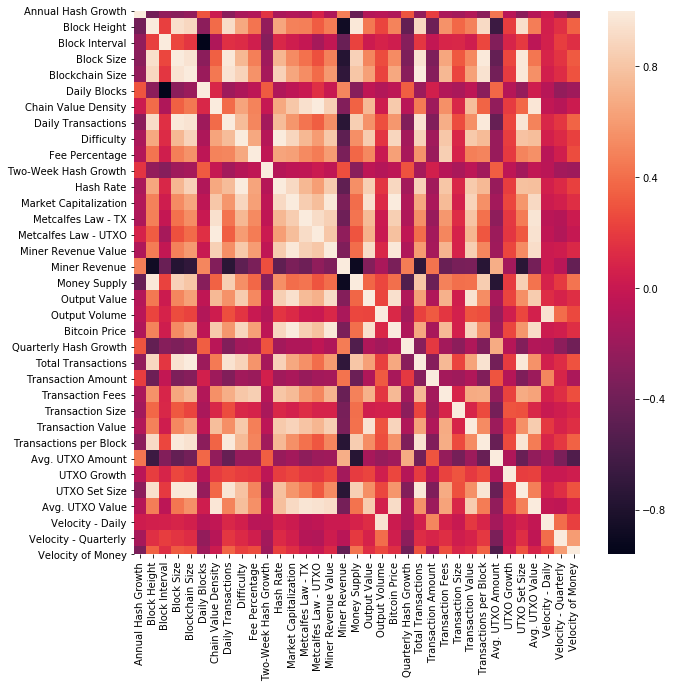

In [ ]:
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns)
plt.show()

**FEATURE SELECTION**

Features to be kept(20): 0,5,9,10,11,16,17,20,21,23,24,25,26,28,29,30,31,32,33,34 

Redundant features to be removed(15): 1,2,3,4,6,7,8,12,13,14,15,18,19,22,27

**DATA PREPROCESSING**

In [ ]:
def load(file, no_of_days):
    
    ini_data = pd.read_csv(file, dtype = float).values

    # keeping only the required features
    data=ini_data[:, [0,5,9,10,11,16,17,20,21,23,24,25,26,28,29,30,31,32,33,34]] 
        
    # To deal with features with missing values, we assume that when a value is unavailable, 
    # we take the value from previous day
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
            if(data[i][j] == 0):
                data[i][j] = data[i-1][j]
    
    # Sliding window transformation to the data
    # Slide an imaginary window over the the data to make a 3D array
    # i.e. an array of arrays of 50 days by 20 features
    swdata = []
    for i in range(len(data) - no_of_days):
        swdata.append(data[i: i + no_of_days])
    
    # Normalizing the data in each window
    d0 = np.array(swdata)
    dr = np.zeros_like(d0)
    dr[:,1:,:]=(d0[:,1:,:]/d0[:,0:1,:]) -1

    # 90% training, 10% testing 
    split=int(0.9 * dr.shape[0])

    # Keeping the unnormalized prices for Y_test
    # Useful when graphing bitcoin price over time later
    # Note: windows are overlapping. Bitcoin price is 8th column after feature reduction.
    unnormalized_bases = d0[split:,0:1,7]

    train_data = dr[:split,:,:]
    test_data = dr[split:,:,:]
    
    # Shuffle the data. 
    # The training data will be shuffled such that the order of days in each window remains consistent
    # but the order of the windows will be random.
    np.random.shuffle(train_data)
    
    #Training Data. Bitcoin Price is the 8th colomn. 
    X_train = train_data[:, :-1,:] # learns from 49 days
    Y_train = train_data[:, -1,:] # output values of all features on 50th day
    Y_train = Y_train[:, 7] # output value of Bitcoin price on 50th day
    
    #Testing data
    X_test = test_data[:, :-1,:]
    Y_test = test_data[:, -1, :]
    Y_test = Y_test[:,7]

    # Keep track of the day before Y_test's price to note increase or decrease
    Y_daybefore = test_data[:, no_of_days-2, :]
    Y_daybefore = Y_daybefore[:, 7]
    
    window_size = no_of_days-1  # because the last value is reserved as the y value
    
    return X_train, Y_train, X_test, Y_test, Y_daybefore, unnormalized_bases, window_size

**THE MODEL**

In [ ]:
def ini_model(window_size, dropout_value, activation_function, loss_function, optimizer):
    
    model = Sequential()

    #First recurrent layer with dropout
    model.add(Bidirectional(LSTM(window_size, dropout=dropout_value, return_sequences=True), input_shape=(window_size, X_train.shape[-1]),))
    
    #Second recurrent layer with dropout
    model.add(Bidirectional(LSTM((2*window_size), dropout=dropout_value, return_sequences=True)))
   
    #Third recurrent layer
    model.add(Bidirectional(LSTM(window_size, return_sequences=False)))

    #Output layer (returns the predicted value)
    model.add(Dense(units=1))
    
    #Set activation function
    model.add(Activation(activation_function))

    #Set loss function and optimizer
    model.compile(loss=loss_function, optimizer=optimizer)
    
    return model

**TRAINING**

In [ ]:
def train(model, X_train, Y_train, batch_no, epoch, split):
    
    # Training starts at this time
    start = time.time()

    model.fit(X_train, Y_train, batch_size=batch_no, epochs=epoch, validation_split= split)

    #Calculate time it took to train the model (in seconds)
    training_time = int(math.floor(time.time() - start))
    return model, training_time

**TESTING**

In [ ]:
def test(model, X_test, Y_test, unnormalized_bases):
    
    #Test the model on X_Test
    y_predict = model.predict(X_test)

    #Create empty 2D arrays to store unnormalized values
    real_y_test = np.zeros_like(Y_test)
    real_y_predict = np.zeros_like(y_predict)

    #Fill the 2D arrays with the real value and the predicted value by reversing the normalization process
    for i in range(Y_test.shape[0]):
        y = Y_test[i]
        predict = y_predict[i]
        real_y_test[i] = (y+1)*unnormalized_bases[i]
        real_y_predict[i] = (predict+1)*unnormalized_bases[i]

    #Plot of the predicted prices versus the real prices
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.set_title("Bitcoin Price Over Time")
    plt.plot(real_y_predict, color = 'green', label = 'Predicted Price')
    plt.plot(real_y_test, color = 'red', label = 'Real Price')
    ax.set_ylabel("Price (USD)")
    ax.set_xlabel("Time (Days)")
    ax.legend()
    
    return y_predict, real_y_test, real_y_predict, fig

**PRICE CHANGE**

In [ ]:
def price_change(Y_daybefore, Y_test, y_predict):
    
    #Reshaping Y_daybefore and Y_test
    Y_daybefore = np.reshape(Y_daybefore, (-1, 1))
    Y_test = np.reshape(Y_test, (-1, 1))

    #The difference between each predicted value and the value from the day before
    delta_predict = (y_predict - Y_daybefore) / (1+Y_daybefore)

    #The difference between each true value and the value from the day before
    delta_real = (Y_test - Y_daybefore) / (1+Y_daybefore)

    #Plotting the predicted percent change versus the real percent change
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.set_title("Percent Change in Bitcoin Price Per Day")
    plt.plot(delta_predict, color='green', label = 'Predicted Percent Change')
    plt.plot(delta_real, color='red', label = 'Real Percent Change')
    plt.ylabel("Percent Change")
    plt.xlabel("Time (Days)")
    ax.legend()
    plt.show()
    
    return Y_daybefore, Y_test, delta_predict, delta_real, fig

**PERCENTAGE PRICE CHANGE**

In [ ]:
def binary_price(delta_predict, delta_real):
    
    #Empty arrays where a 1 represents an increase in price and a 0 represents a decrease in price
    delta_predict_1_0 = np.empty(delta_predict.shape)
    delta_real_1_0 = np.empty(delta_real.shape)

    #If the change in price is greater than zero, store it as a 1
    #If the change in price is less than zero, store it as a 0
    for i in range(delta_predict.shape[0]):
        if delta_predict[i][0] > 0:
            delta_predict_1_0[i][0] = 1
        else:
            delta_predict_1_0[i][0] = 0
    for i in range(delta_real.shape[0]):
        if delta_real[i][0] > 0:
            delta_real_1_0[i][0] = 1
        else:
            delta_real_1_0[i][0] = 0  

    return delta_predict_1_0, delta_real_1_0

**COMPARING PREDICTIONS AND REAL**

In [ ]:
def find_positives_negatives(delta_predict_1_0, delta_real_1_0):
    
    #Finding the number of false positive/negatives and true positives/negatives
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    for i in range(delta_real_1_0.shape[0]):
        real = delta_real_1_0[i][0]
        predicted = delta_predict_1_0[i][0]
        if real == 1:
            if predicted == 1:
                true_pos += 1
            else:
                false_neg += 1
        elif real == 0:
            if predicted == 0:
                true_neg += 1
            else:
                false_pos += 1
    return true_pos, false_pos, true_neg, false_neg

**STATISTICS**

In [ ]:
def calculate_statistics(true_pos, false_pos, true_neg, false_neg, y_predict, Y_test):
    
    precision = float(true_pos) / (true_pos + false_pos)
    recall = float(true_pos) / (true_pos + false_neg)
    F1 = float(2 * precision * recall) / (precision + recall)
    #Get Mean Squared Error
    MSE = mean_squared_error(y_predict.flatten(), Y_test.flatten())

    return precision, recall, F1, MSE

**FINAL**

In [ ]:
X_train, Y_train, X_test, Y_test, Y_daybefore, unnormalized_bases, window_size = load("MISIG_data.csv", 50)
print ('Dimension of X_train:',X_train.shape)
print ('Dimension of Y_train:',Y_train.shape)
print ('Dimension of X_test:',X_test.shape)
print ('Dimension of Y_test:',Y_test.shape)
print ('Dimension of Y_daybefore:',Y_daybefore.shape)
print ('Dimension of unnormalised_bases:',unnormalized_bases.shape)
print ('Window size:',window_size)

Dimension of X_train: (2400, 49, 20)
Dimension of Y_train: (2400,)
Dimension of X_test: (267, 49, 20)
Dimension of Y_test: (267,)
Dimension of Y_daybefore: (267,)
Dimension of unnormalised_bases: (267, 1)
Window size: 49


In [ ]:
model = ini_model(window_size, 0.2, 'linear', 'mse', 'adam')
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 49, 98)            27440     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 49, 196)           154448    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 98)                96432     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 99        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 278,419
Trainable params: 278,419
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model, training_time = train(model, X_train, Y_train, 1024, 100, .05)
print("Training time", training_time, "seconds")

2280/2280 [==============================] - 8s 4ms/step - loss: 2.7254 - val_loss: 6.4917
Epoch 2/100
2280/2280 [==============================] - 3s 1ms/step - loss: 2.1329 - val_loss: 5.6410
Epoch 3/100
2280/2280 [==============================] - 2s 1ms/step - loss: 1.8196 - val_loss: 5.2728
Epoch 4/100
2280/2280 [==============================] - 2s 1ms/step - loss: 1.6001 - val_loss: 4.9794
Epoch 5/100
2280/2280 [==============================] - 3s 1ms/step - loss: 1.3225 - val_loss: 4.7050
Epoch 6/100
2280/2280 [==============================] - 3s 1ms/step - loss: 1.2226 - val_loss: 4.3408
Epoch 7/100
2280/2280 [==============================] - 2s 1ms/step - loss: 1.0704 - val_loss: 3.8915
Epoch 8/100
2280/2280 [==============================] - 3s 1ms/step - loss: 0.9408 - val_loss: 3.4597
Epoch 9/100
2280/2280 [==============================] - 2s 1ms/step - loss: 0.8259 - val_loss: 3.1394
Epoch 10/100
2280/2280 [==============================] - 3s 1ms/step - loss: 0.7902 

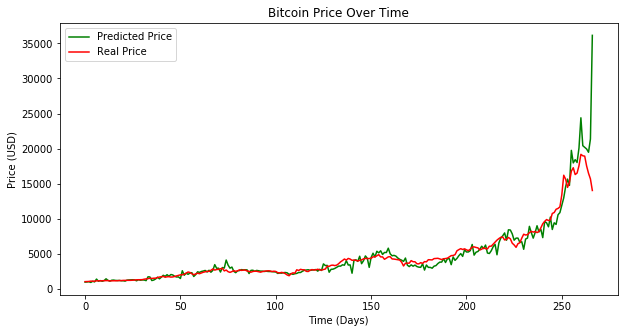

In [ ]:
y_predict, real_y_test, real_y_predict, fig1 = test(model, X_test, Y_test, unnormalized_bases)
plt.show(fig1)

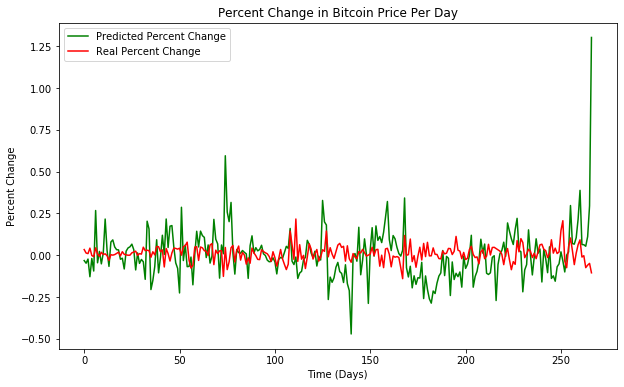

In [ ]:
Y_daybefore, Y_test, delta_predict, delta_real, fig2 = price_change(Y_daybefore, Y_test, y_predict)
plt.show(fig2)

In [ ]:
delta_predict_1_0, delta_real_1_0 = binary_price(delta_predict, delta_real)

In [ ]:
true_pos, false_pos, true_neg, false_neg = find_positives_negatives(delta_predict_1_0, delta_real_1_0)
print ("True positives:", true_pos)
print ("False positives:", false_pos)
print ("True negatives:", true_neg)
print ("False negatives:", false_neg)

True positives: 83
False positives: 46
True negatives: 53
False negatives: 85


In [ ]:
precision, recall, F1, MSE = calculate_statistics(true_pos, false_pos, true_neg, false_neg, y_predict, Y_test)
print ("Precision:", precision)
print ("Recall:", recall)
print ("F1 score:", F1)
print ("Mean Squared Error:", MSE)

Precision: 0.6434108527131783
Recall: 0.49404761904761907
F1 score: 0.558922558922559
Mean Squared Error: 0.09091333847963416
